In [1]:
#Imports

# base
import numpy as np
import pandas as pd
from scipy import stats

# keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


Notes: Next steps include omission of variables in the soundfiles. Need to analyse the channels in the soundfile. Standardscaler for images seem to not do anything sensible. 
Another next step: data augmentation by twisting and skewing the images. Data augmentation by using moving averages for the soundfiles.

Current best results range between 98.95% - 99.18% accuracy with 3 kfolds and 5 epochs. Baseline (when every prediction is set to false) is around 90%.

# 1.1 Load Data

In [2]:
# fix random seed for reproduction
seed = 50
np.random.seed(seed)

#load datafiles
written_train_input = np.load("written_train.npy", allow_pickle=True)
spoken_train_input = np.load("spoken_train.npy", allow_pickle=True)
match_train_input = np.load("match_train.npy", allow_pickle=True)

# 1.2 Data Exploration

In [3]:
print('written_train_input:', written_train_input.shape)
print(written_train_input[0])
print()
print('spoken_train_input:', spoken_train_input.shape)
print(spoken_train_input[0])
print()
print('match_train_input:', match_train_input.shape)
print(match_train_input[0])

written_train_input: (45000, 784)
[255 254 254 255 254 253 255 254 255 255 255 255 255 254 251 254 255 255
 255 255 253 255 255 255 255 255 255 255 255 255 254 255 255 255 253 255
 255 253 254 255 255 255 255 255 255 255 252 255 253 254 250 254 255 250
 255 255 255 253 255 255 255 255 252 255 251 255 255 255 255 253 255 255
 251 254 255 254 255 255 250 255 254 255 255 255 253 254 255 254 254 254
 255 253 255 255 255 249 255 255 255 255 254 255 254 254 255 255 254 253
 254 253 255 255 255 252 255 255 255 255 255 255 255 255 254 255 254 243
 128  63 137 251 255 255 254 255 255 255 255 255 255 255 252 254 255 252
 255 251 253 252 255 255 255 255 241  82   3   2   0  66 219 255 255 251
 253 253 255 255 255 253 255 254 255 253 255 255 255 255 255 254 255 253
 120   2   0   4  46   2  31 219 255 255 255 255 253 255 254 254 255 255
 253 254 255 255 253 254 255 255 255 186   3   3  71 148 251 158   4 167
 255 253 253 255 255 255 255 254 254 255 252 251 252 255 255 255 255 255
 254 132   4   6 

In [4]:
print(spoken_train_input[0][0])
print(spoken_train_input[0][1])

print('length element [0][0]:', len(spoken_train_input[0][0]))
print('length element [0][1]:', len(spoken_train_input[0][1]))

print('length element [0][:]:', len(spoken_train_input[0][:]))
print('length element [5][:]:', len(spoken_train_input[5][:]))

[ 1.3085   -0.093684 -0.11652  -0.020097 -0.14939  -1.6002   -0.59698
 -0.23489   0.97998   0.50539   0.2713   -0.10654  -0.69459 ]
[ 1.4695     0.23906    0.25311    0.015213   0.0088486 -1.3117
 -0.8433    -0.22086    0.47642    0.25476    0.17071    0.16774
 -0.30055  ]
length element [0][0]: 13
length element [0][1]: 13
length element [0][:]: 41
length element [5][:]: 28


Observations:
- written_train contains black and white pixel values as numpy arrays. There are 45000 inputs, with the length 784. These 784 pixels have to be reshaped to a 28x28 format if we want to use CNN's. 

- spoken_train has an 'array of arrays' format. These arrays have to be unpacked to parse them through any type of ML model. The shape of spoken_train: (45000,). Spoken_train contains 13 sound channels. Each soundfile has a varying length. So the essential format is (45000, 13, N), where N equals the length of the soundfile.

- match_train_input (45000) solely consists of TRUE and FALSE to tell us whether the n'th written file matches the n'th spoken file. 



Visuals

In [5]:
import matplotlib.pyplot as plt 

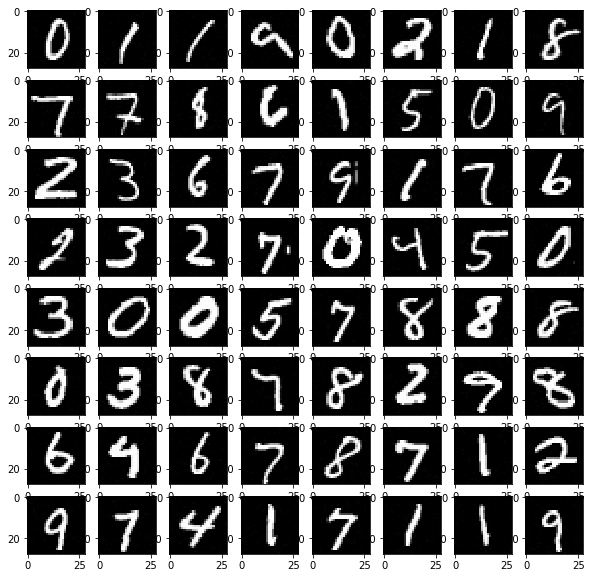

In [6]:
# Visualize the first image from the training dataset
written_train_graph = np.reshape(written_train_input, (written_train_input.shape[0], 28,28))

# first 64 written files
plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8,8, i+1)
    plt.grid(False)
    plt.imshow(written_train_graph[i], cmap=plt.cm.binary)

Important note; there seem to be artifacts in some images. Find means to eliminate these? Not implemented yet

# 1.3 Preprocessing data

Preprocess written dataset / i.e. pixels:

In [7]:
#preprocess and apply standardscaler to the 'written' dataset. Scales according to z-values/bell-curve. 
def written_preprocess(written_data):
    #transform/rescale pixels from range 0-255 to a range between 0-1.
    written_train = written_data/255.0
    
    # every pixel which has an 'intensity' of less than 3% is set to 0%, and more than 97% is set set 100%
    written_train[written_train>0.97] = 1
    written_train[written_train<0.03] = 0
    
    #apply standardscaler
    #sc_w = StandardScaler()
    #written_train = sc_w.fit_transform(written_data)
    return written_train

written_train = written_preprocess(written_train_input)

Preprocess spoken dataset / i.e. soundfiles. Contains padding and extends soundfiles to perform a CNN model on them. The aim is to treat the sound as an 13-color channel image:

In [8]:
def spoken_preprocess(spoken_data):
    #to be able to analyse the 45000 soundfiles, they all have to be equally long in size for any ML model to work.
    #PADDING:
    
    #pad 0's to all length arrays which are shorter than the longest array
    create_same_lengths = True
    
    if create_same_lengths:
        lengths_spoken = np.empty(len(spoken_data))
        for index, value in enumerate(spoken_data):
            lengths_spoken[index] = value.shape[0]
        
        sorted_lengths = np.sort(lengths_spoken)
        longest_length = sorted_lengths[-1]
        
        padded_spoken = []
        
        # Fill the empty array created above
        N = longest_length
        for sound in spoken_data:
    
            if sound.shape[0] < N:
                pad_size = N - sound.shape[0]
                length = sound.shape[1]
                
                pad_array = np.zeros((13,), dtype=np.int)
                x = np.tile(pad_array, (int(pad_size),1))
                sound = np.concatenate((sound, x), axis=0)
                padded_spoken.append(sound)
            else:
                padded_spoken.append(sound)
    
    
    #transform the list of all padded arrays to a numpy array and reshape to flat arrays            
    spoken_train_feat = np.array(padded_spoken).reshape(spoken_data.shape[0],int(N),13)
    
    ######### --------------------  EXPERIMENTAL PART ------------------------ ##########
    # deletes one or more of the channels.
    
    #spoken_train_feat = spoken_train_feat[:][:][:12]
    b = np.zeros((spoken_train_feat.shape[0],100,spoken_train_feat.shape[2]))
    b[:,:-7] = spoken_train_feat
    spoken_train_feat = b
    
    del b
    ######### --------------------  EXPERIMENTAL PART ------------------------ ##########
    
    spoken_train = spoken_train_feat.reshape(spoken_train_feat.shape[0],spoken_train_feat.shape[1]\
                                           * spoken_train_feat.shape[2])
    
    #rescale with standardscaler
    sc_s = StandardScaler(with_mean=False)
    
    spoken_scaled = sc_s.fit_transform(spoken_train)
    spoken_train_feat_image = np.reshape(spoken_scaled, (spoken_scaled.shape[0],100,13))

    return spoken_train_feat_image


In [9]:
spoken_train_feat_image = spoken_preprocess(spoken_train_input)

# The graph below is to help identify patterns in sound to check the behaviour of channels

In [10]:
#from matplotlib import cm
#
#mfcc_feat = spoken_train_feat_image[25]
#
#ig, ax = plt.subplots()
#mfcc_data= np.swapaxes(mfcc_feat, 0 ,1)
#cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
#ax.set_title('MFCC')
##Showing mfcc_data
#plt.show()
##Showing mfcc_feat
#plt.plot(mfcc_feat)
#plt.show()
#
#print(spoken_train_feat_image[25][20])

In [11]:
print(spoken_train_feat_image.shape)

(45000, 100, 13)


In [12]:
spoken_train_feat_image = np.reshape(spoken_train_feat_image, (45000,10,10,13))

Use the portion below if you opt to not treat the soundfiles as CNN input. This requires reworking the "experimental" part in the padding section as well.

In [13]:
#concatenate numpy arrays which are both rescaled
#features = np.concatenate([spoken_train1,
#                           written_train], axis = 1)

In [14]:
#create pandas dataframe for visualisation of concatenated arrays
#index = range(0, len(features))
#columns = range(0,features.shape[1])
#
#nn = pd.DataFrame(data = features, index=range(0,features.shape[0]), columns=range(0,features.shape[1]))
#nn.head()

In [15]:
#get values of the arrays to be used in the model
#X = nn.values
#y = match_train_input
#

In [16]:
#print(X.shape)
#
##X[X>2.8] = 2.8
##X[X<-2.8] = -2.8
#
#print(X[4][5])
#

# 2.1 Initialize ML / NN model

For this project we'll be using a two-branch neural network. One branch for image-feature focused ML, and the other branch for sound-feature focused ML.

CNN's are the most effective models for image analysis, especially for the MNIST Digit classification purposes.
My idea is to treat the soundfiles as images as well. So we'll be applying a CNN model on the soundfiles too. The appropriate preprocessing has been done to facilitate this step.

The final step is to join all nodes from both branches to eachother to get the necessary True/False predictions.

In [17]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
 


# 2.1.1 Sound Trainer Function

In [18]:
# Create CNN to analyze soundfiles.
def create_cnn_sound(width, height, depth, filters=(16, 32, 64)):
    # initialize the input shape and channel dimension, assuming TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
    
    # define the model input
    inputs = Input(shape=inputShape)
    
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        
        # if this is the first convolutional layer, set input
        if i == 0:
            x = inputs
    
        # Convolve, activate, batch normalization, pooling
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then the layers: fully connect, activate, normalize and dropout
    # dense layer has 1300 nodes; 1 for soundframe
    x = Flatten()(x)
    x = Dense(1300)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    
    # fully connected layer to match the output of the other CNN model
    x = Dense(512)(x)
    x = Activation("relu")(x)
    
    # construct the CNN
    model = Model(inputs, x)
    
    # return the CNN
    return model



# 2.1.2 Image Trainer Function

In [19]:
# Create CNN to analyze images
def create_cnn_image(width, height, depth, filters=(16, 32, 64)):
    # initialize the input shape and channel dimension, assuming TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
    
    # define the model input
    inputs = Input(shape=inputShape)
    
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first convolutional layer, set input
        if i == 0:
            x = inputs
    
        # Convolve, activate, batch normalization, pooling
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then the layers: fully connect, activate, normalize and dropout
    # dense layer has 1300 nodes; 1 for soundframe 
    x = Flatten()(x)
    x = Dense(784)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
    
    # fully connected layer to match the output of the other CNN model
    x = Dense(512)(x)
    x = Activation("relu")(x)
    
    # construct the CNN
    model = Model(inputs, x)
    
    # return the CNN
    return model

In [20]:
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.layers import concatenate
import numpy as np

In [21]:
# Check the shapes of the data
print(spoken_train_feat_image.shape)
print(written_train.shape)

(45000, 10, 10, 13)
(45000, 784)


# 2.1.3 Split training data into training + val

I used a simple split here by just using the first 30000 datapoints of each dataset (written, spoken, match) as training data and the last 15000 datapoints as test data:

In [22]:
#from sklearn.model_selection import train_test_split
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

spoken_train_feat_image1 = np.reshape(spoken_train_feat_image, (45000,10,10,13))
written_train1 = np.reshape(written_train, (written_train.shape[0], 28,28,1))


trainAttrX = spoken_train_feat_image1[:30000]
valAttrX = spoken_train_feat_image1[30000:]
trainImagesX = written_train1[:30000]
valImagesX = written_train1[30000:]

    
#Split target into training and validation data
trainY = match_train_input[:30000]
valY = match_train_input[30000:]


# 2.2 Join CNN functions and output

In [23]:
# create the MLP and CNN models. 
cnn_sound = create_cnn_sound(10, 10, 13) #sounds
cnn_image = create_cnn_image(28, 28, 1) #images
 
# join both models
combinedInput = concatenate([cnn_sound.output, cnn_image.output])
 
# finalize with another fully connected layer and the last layer having 1 output for true/false
# play around with the size of the fully connected layer for better performance
x = Dense(100, activation="relu")(combinedInput)
x = Dense(1, activation="sigmoid")(x)
 
# finalize model
model = Model(inputs=[cnn_sound.input, cnn_image.input], outputs=x)

W0822 13:09:15.148383 71080 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0822 13:09:15.159354 71080 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0822 13:09:15.161349 71080 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0822 13:09:15.180298 71080 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0822 13:09:15.180298 71080 deprecation_wrapper.py:119] 

# 2.3 Compile and Fit model with Kfold-crossvalidation 

The Kfold is optional. I need to test performance with and without Kfolds and set them out against eachother in charts to compare both accuracy and changes in training speed. One of the next steps is to automate the script to check whether kfold has any added value compared to just simply splitting the data.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold


In [25]:
#prepare cross validation
Kfold = KFold(3, random_state=2, shuffle=True)

# two optimizers to try
opt = Adam(lr=1e-3, decay=1e-3 / 200)
optimizer = Adamax(lr=0.002,
                 beta_1=0.9, beta_2=0.999)

# Compile final ML model
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

# containers to track accuracies and histories
accuracies, histories = list(), list()

# train model by means of repeated Kfold
for train_index, test_index in Kfold.split(trainAttrX, trainY):
    trainAttrX9000, testAttrX9000 = trainAttrX[train_index], trainAttrX[test_index]
    trainImagesX9000, testImagesX9000 = trainImagesX[train_index], trainImagesX[test_index]
    y_train, y_val = trainY[train_index], trainY[test_index]
    print('Data has been splitted like this:', trainAttrX9000.shape, trainImagesX9000.shape, y_train.shape, y_val.shape)
    
    # train model
    history = model.fit(
        [trainAttrX9000, trainImagesX9000], y_train,
        validation_data=([testAttrX9000, testImagesX9000], y_val),
        epochs=5, batch_size=100)
    
    # evaluate model to check development of accuracy over epochs
    _, accuracy = model.evaluate([testAttrX9000, testImagesX9000], y_val, verbose=0)
    print('> %.3f' % (accuracy*100.0))
    
    # store accuracies
    accuracies.append(accuracy)
    histories.append(history)


W0822 13:09:15.792896 71080 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0822 13:09:15.798878 71080 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Data has been splitted like this: (20000, 10, 10, 13) (20000, 28, 28, 1) (20000,) (10000,)
Train on 20000 samples, validate on 10000 samples
Epoch 1/5
20000/20000 [==============================] - 27s 1ms/step - loss: 0.3614 - acc: 0.8957 - val_loss: 0.3161 - val_acc: 0.8952
Epoch 2/5
20000/20000 [==============================] - 26s 1ms/step - loss: 0.2689 - acc: 0.9035 - val_loss: 0.2411 - val_acc: 0.9071
Epoch 3/5
20000/20000 [==============================] - 26s 1ms/step - loss: 0.2033 - acc: 0.9124 - val_loss: 0.2156 - val_acc: 0.9105
Epoch 4/5
20000/20000 [==============================] - 26s 1ms/step - loss: 0.1541 - acc: 0.9291 - val_loss: 0.1832 - val_acc: 0.9120
Epoch 5/5
20000/20000 [==============================] - 26s 1ms/step - loss: 0.1052 - acc: 0.9558 - val_loss: 0.1455 - val_acc: 0.9474
> 94.740
Data has been splitted like this: (20000, 10, 10, 13) (20000, 28, 28, 1) (20000,) (10000,)
Train on 20000 samples, validate on 10000 samples
Epoch 1/5
20000/20000 [======

# Graphing accuracies and val_loss

Note: Haven't been able to make the below script print a single chart with the results from kfold yet. Does work without kfolds.

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


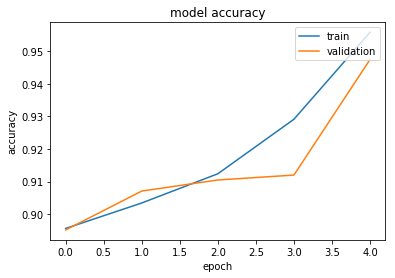

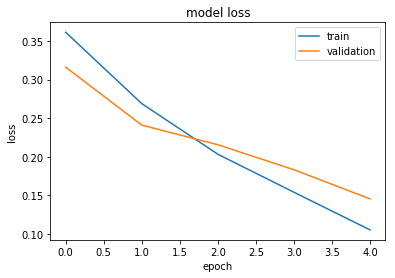

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


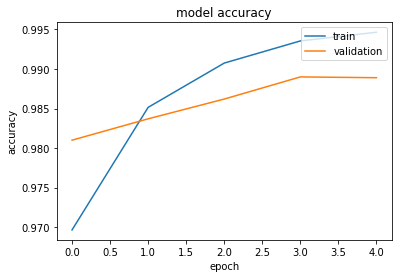

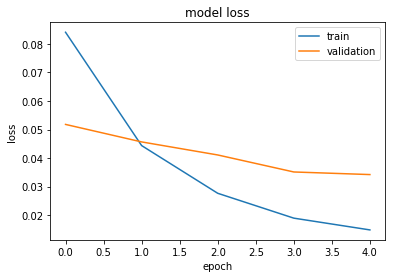

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


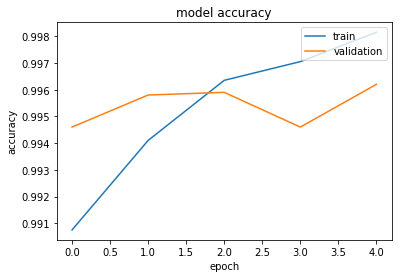

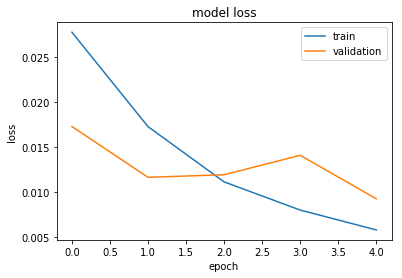

In [26]:
import matplotlib.pyplot as plt

for i in range(len(histories)):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(histories[i].history['acc'])
    plt.plot(histories[i].history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    # summarize history for loss
    plt.plot(histories[i].history['loss'])
    plt.plot(histories[i].history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


# 2.4 Sanity Check, Predictions on held out validation set

In [27]:
y_pred = model.predict([valAttrX, valImagesX])
y_predict = (y_pred > 0.5)

Simple confusion matrix:

In [28]:
# Simple confusion matrix

# TN, FP
# FN, TP

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(valY, y_predict)
correctpercentage = (cm[0][0] + cm[1][1]) / (cm[1][0] + cm[0][1] + cm[0][0] + cm[1][1])
print('confusion matrix:\n', cm)
print('\npercentage correctly predicted inside partitioned training set:\n' + str(correctpercentage*100) + '%')

confusion matrix:
 [[13428    48]
 [  110  1414]]

percentage correctly predicted inside partitioned training set:
98.94666666666667%


# Predict final dataset of challenge

Load testing files:

In [29]:
written_test_input = np.load("written_test.npy", allow_pickle=True)
spoken_test_input = np.load("spoken_test.npy", allow_pickle=True)

In [30]:
#apply standardscaler to the 'written' dataset, reshape to 4D for CNN
written_test = written_preprocess(written_test_input)
written_test = np.reshape(written_test, (written_test.shape[0], 28,28,1))

In [31]:
#apply padding and standardscaler to the 'spoken' dataset, reshape to 4D for CNN
spoken_test = spoken_preprocess(spoken_test_input)
spoken_test = np.reshape(spoken_test, (spoken_test.shape[0],10,10,13))

In [32]:
# Shape check. Each variable must be a 4D numpy array of equal length to make the joined CNN's work. 
print(written_test.shape)
print(spoken_test.shape)

(15000, 28, 28, 1)
(15000, 10, 10, 13)


In [33]:
#predict the outcome for the final testset of the challenge
y_test = model.predict([spoken_test, written_test])
y_test_pred = (y_test > 0.5)

total_trues = 0
for i in y_test_pred:
    if i == True:
        total_trues+=1
print(total_trues)

1467


In [34]:
print('estimated labeled positive in final test set: '  + str((total_trues/y_test_pred.shape[0])*100) + '%')

estimated labeled positive in final test set: 9.78%


In [35]:
#flatten result and print to numpy array for handing
result = y_test_pred.flatten()
np.save("result.npy",result)